<a href="https://colab.research.google.com/github/Svsshevch/traffic-sign-project/blob/main/Traffic_Sign_Classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

In [ ]:
!nvidia-smi

Thu Feb  5 00:06:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Import Libraries

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.ops import nms
import xml.etree.ElementTree as ET
import math
import random
import os
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.optim import SGD
import time
import copy
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!rm -rf GTSRB
!rm -f GTSRB_Final_Training_Images.zip*

Download dataset

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2026-02-05 00:07:01--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  16.3MB/s    in 19s     

2026-02-05 00:07:20 (14.0 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

# Exploration of dataset

In [ ]:
total_images = 0

for folder in train_folders:
    total_images += len(glob(f"{folder}/*.ppm"))

print("Number of classes:", len(train_folders))
print("Total images in training set:", total_images)

Number of classes: 43
Total images in training set: 39209


## Dataset visualization

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

In [ ]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

/tmp/ipython-input-628571887.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  images = torch.as_tensor(images)


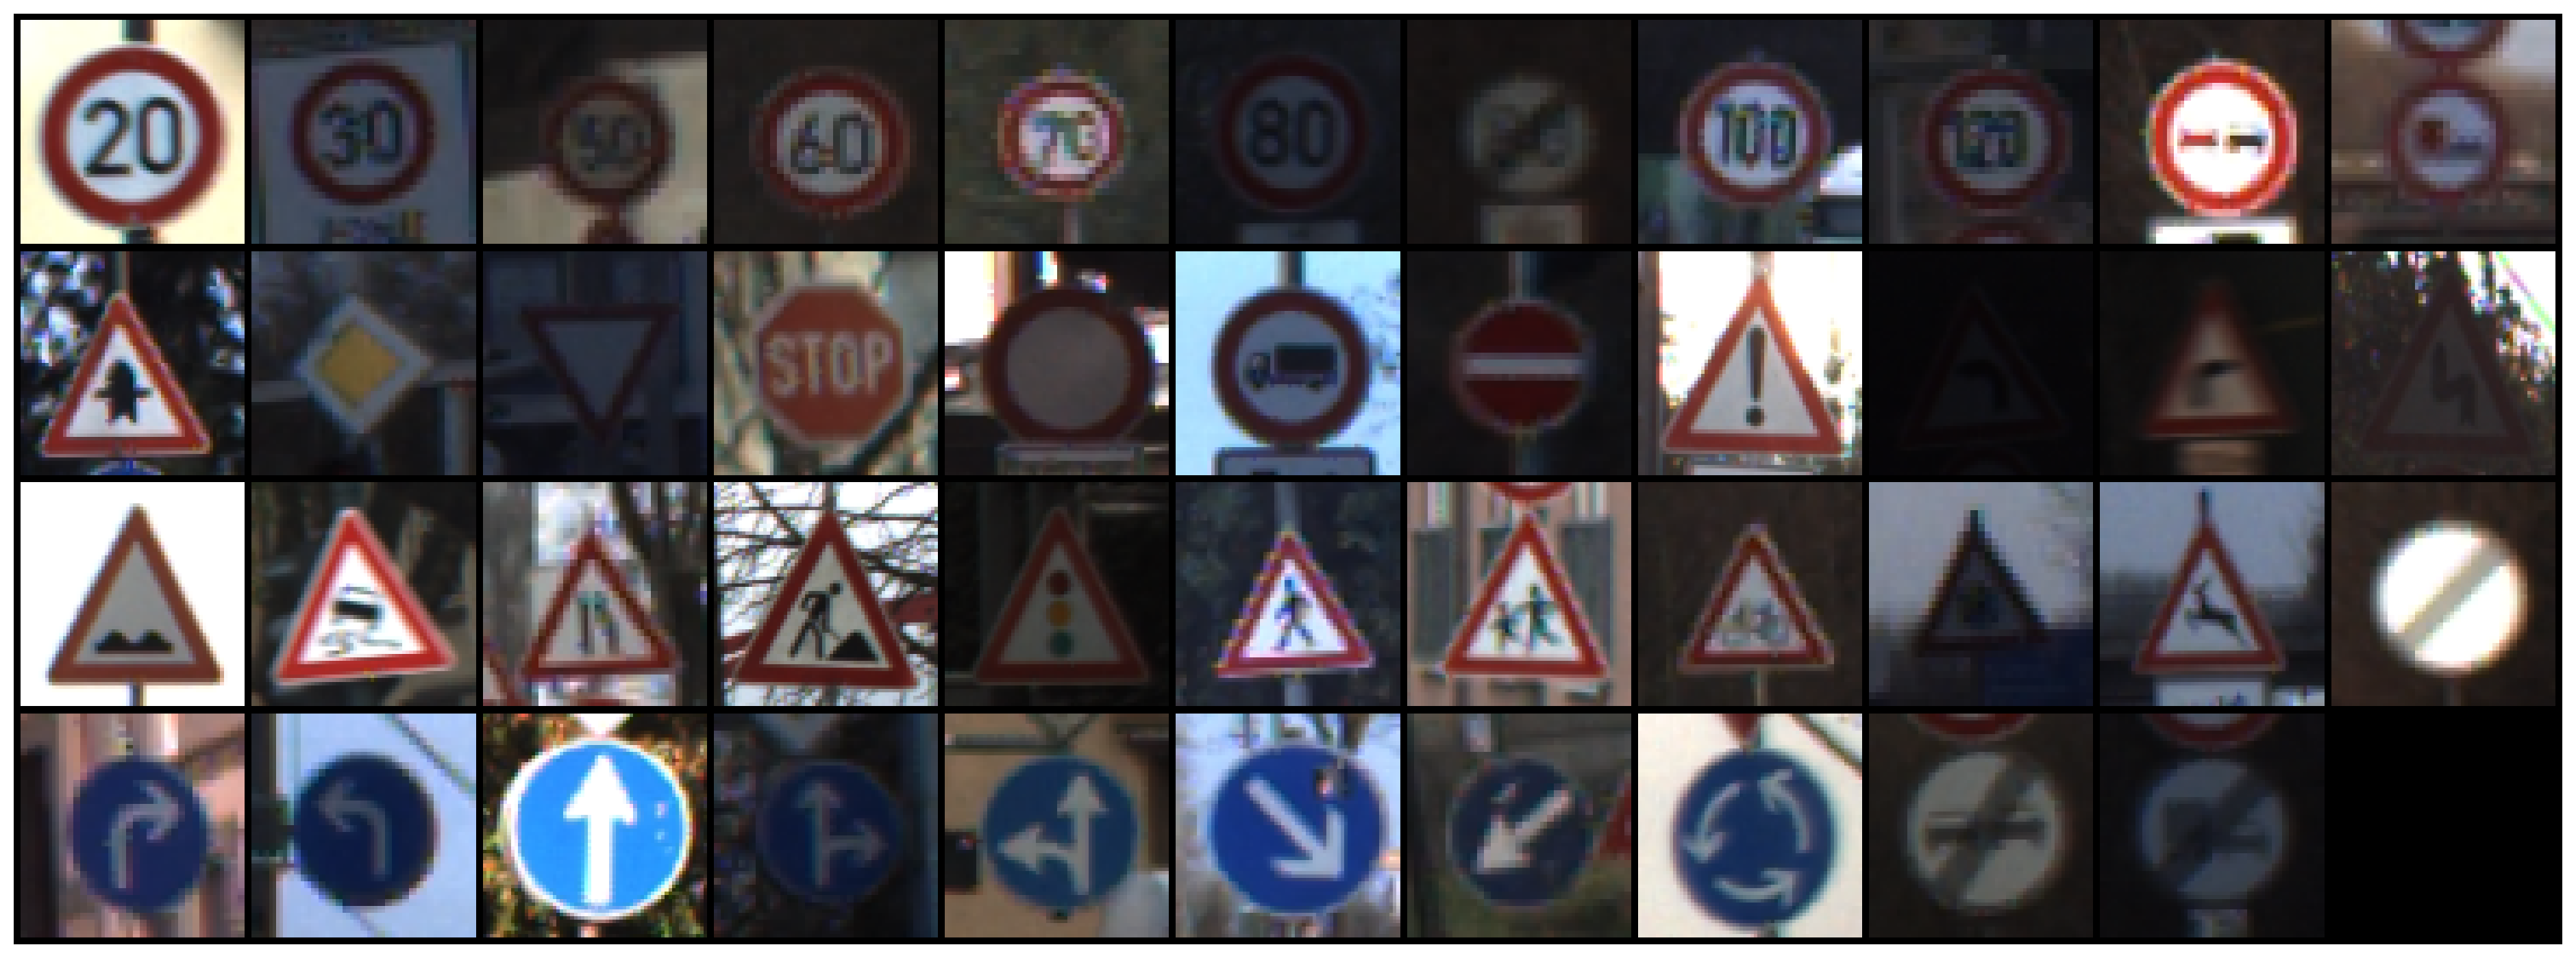

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

## Dataset Distribution

Dataset consists of 43 traffic sign classes with a highly imbalanced class distribution. The number of images per class varies significantly, ranging from 210 images in the smallest classes to 2,250 images in the largest classes. Such imbalance can negatively affect model training by biasing the classifier toward majority classes, potentially reducing performance on underrepresented signs.

Therefore, this dataset requires careful handling, such as:

*   data augmentation for minority classes,
*   class-balanced sampling.





Average per class: 912
Max: 2250 (class 2)
Min: 210 (class 0)
Standard deviation: 688


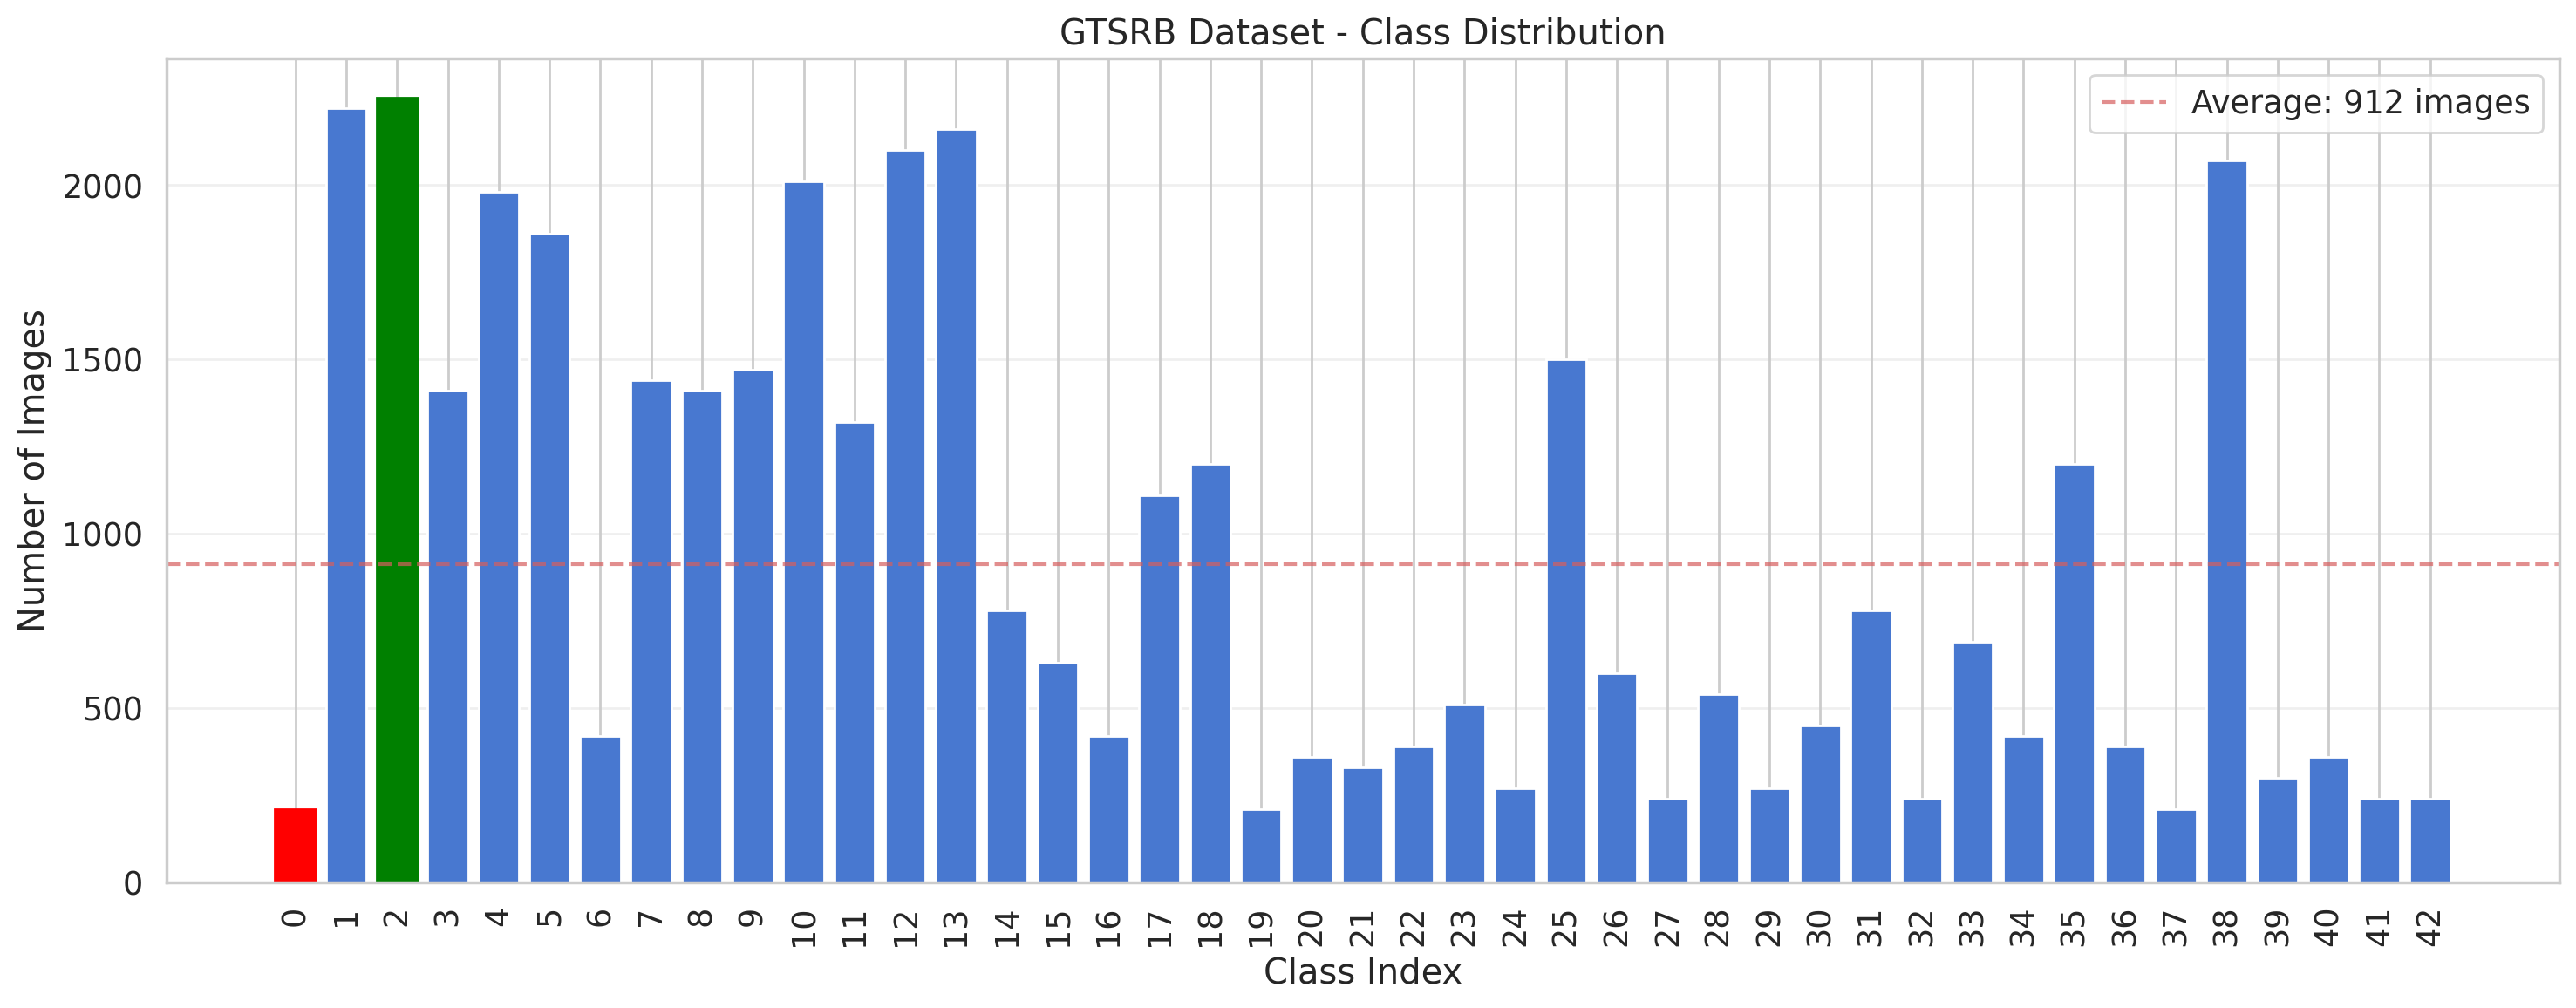

In [ ]:
def plot_class_distribution(train_folders, class_names=None):
    class_counts = []
    labels = []

    for i, folder in enumerate(train_folders):
        image_paths = glob(f'{folder}/*.ppm')
        count = len(image_paths)
        class_counts.append(count)
        if class_names and i < len(class_names):
            labels.append(f"{i}: {class_names[i]}")
        else:
            labels.append(str(i))

    plt.figure(figsize=(15, 6))
    bars = plt.bar(range(len(class_counts)), class_counts)
    plt.xlabel('Class Index')
    plt.ylabel('Number of Images')
    plt.title('GTSRB Dataset - Class Distribution')
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.grid(True, alpha=0.3, axis='y')

    total = sum(class_counts)
    avg = np.mean(class_counts)
    plt.axhline(y=avg, color='r', linestyle='--', alpha=0.7,
                label=f'Average: {avg:.0f} images')

    max_idx = np.argmax(class_counts)
    min_idx = np.argmin(class_counts)
    bars[max_idx].set_color('green')
    bars[min_idx].set_color('red')

    plt.legend()
    plt.tight_layout()

    print(f"Average per class: {avg:.0f}")
    print(f"Max: {max(class_counts)} (class {max_idx})")
    print(f"Min: {min(class_counts)} (class {min_idx})")
    print(f"Standard deviation: {np.std(class_counts):.0f}")

    return class_counts

class_distribution = plot_class_distribution(train_folders)

We analyze image size distribution to choose a suitable crop/resize resolution

Scanning image sizes: 100%|██████████| 43/43 [00:00<00:00, 278.98it/s]


Images analyzed: 2150
Mean resolution: 51.9 x 51.2 (W x H) pixels
Min/Max width:  25 / 221 px
Min/Max height: 25 / 195 px


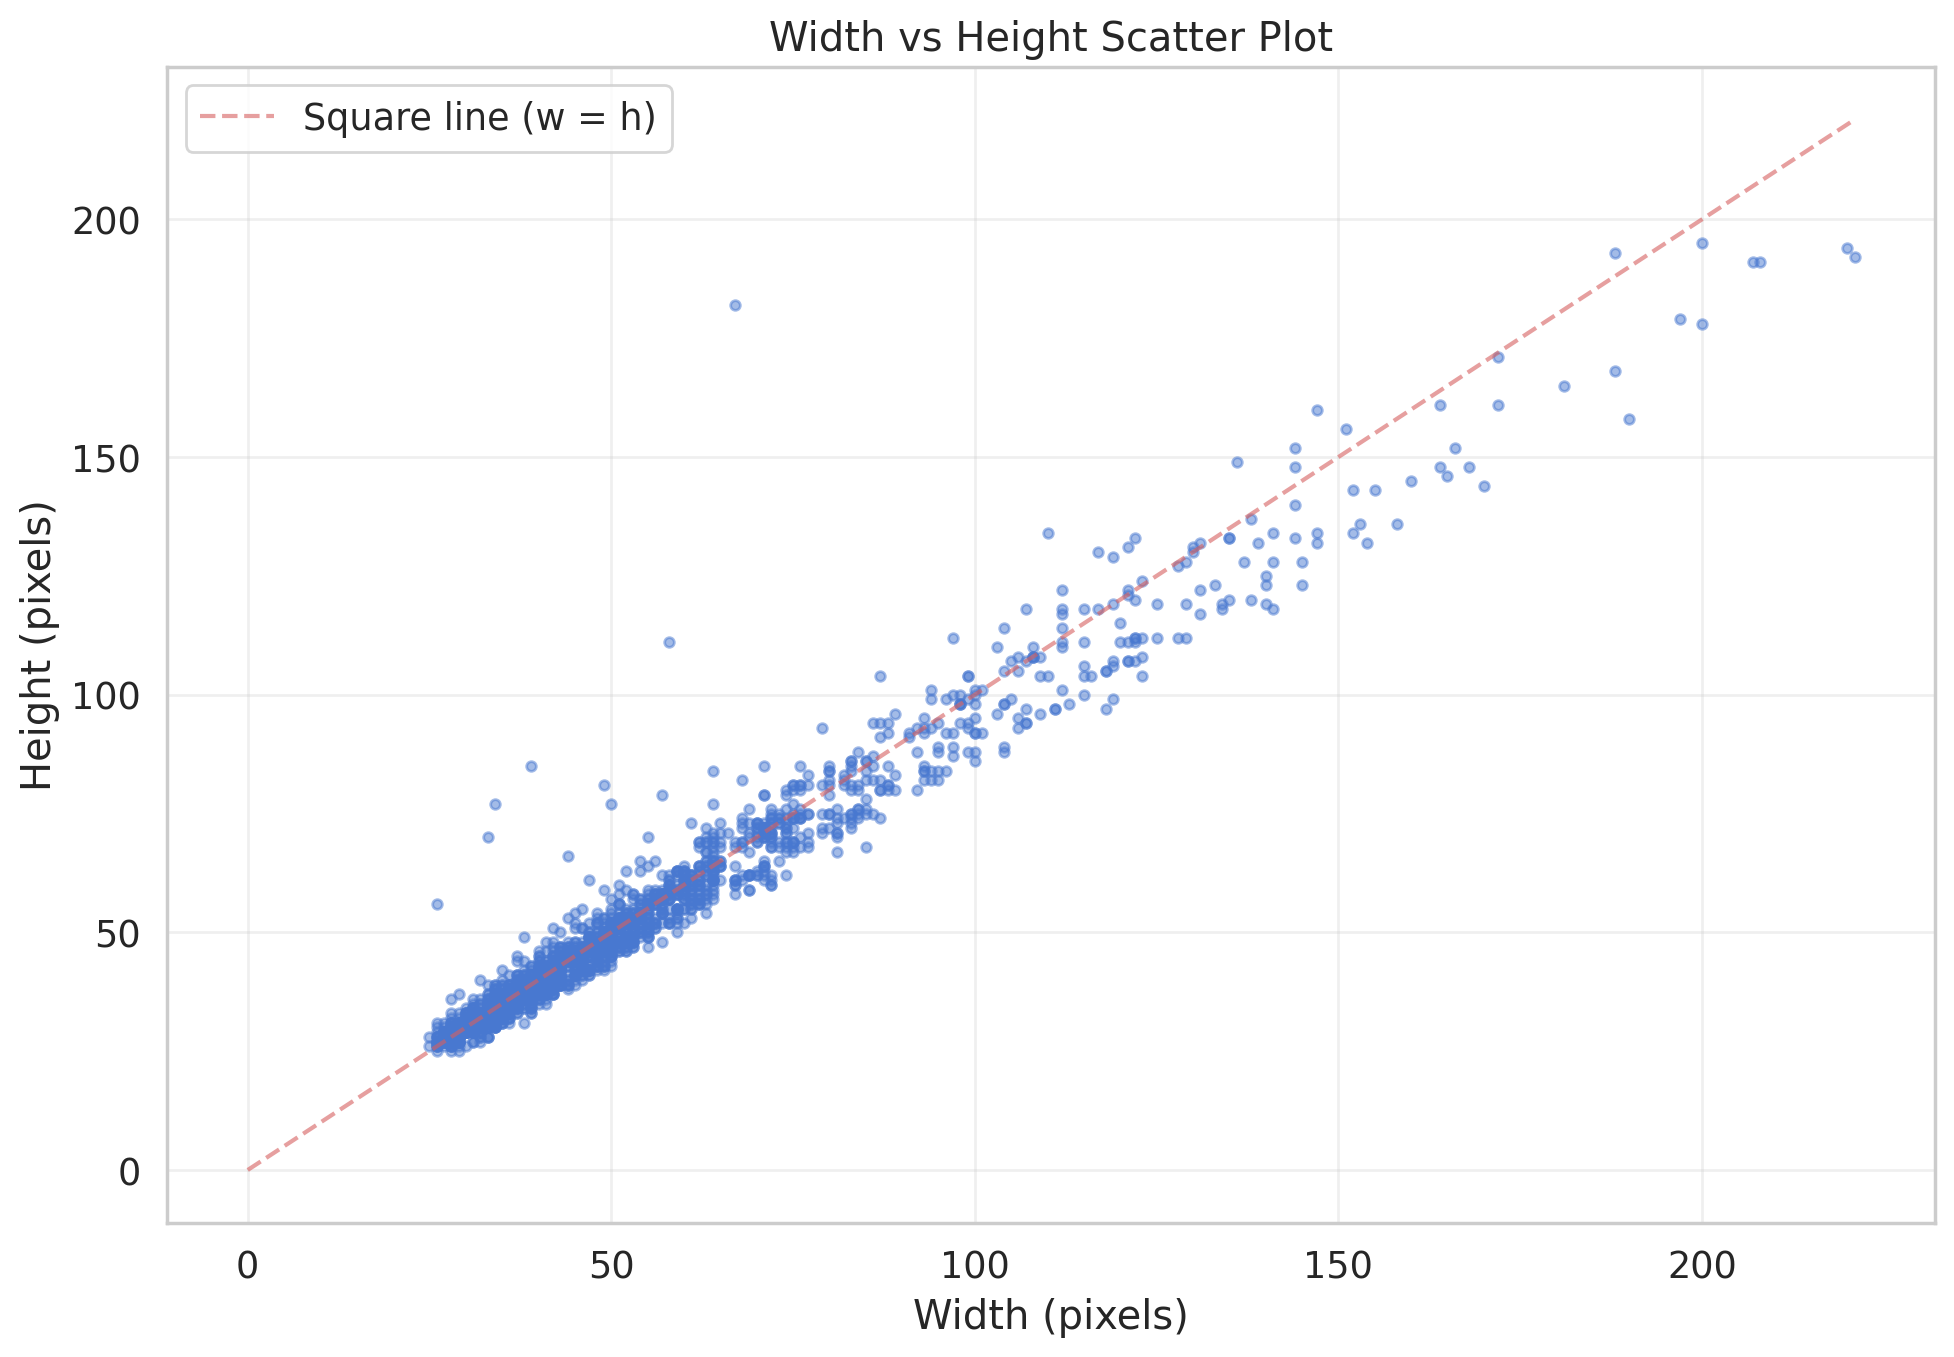

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_mean_size_and_scatter(train_folders, max_imgs_per_class=50):

    folders = train_folders

    widths, heights = [], []

    for folder in tqdm(folders, desc="Scanning image sizes"):
        for img_path in glob(f"{folder}/*.ppm")[:max_imgs_per_class]:
                with Image.open(img_path) as img:
                    w, h = img.size
                widths.append(w)
                heights.append(h)

    widths = np.array(widths)
    heights = np.array(heights)

    mean_w = widths.mean()
    mean_h = heights.mean()

    print(f"Images analyzed: {len(widths)}")
    print(f"Mean resolution: {mean_w:.1f} x {mean_h:.1f} (W x H) pixels")
    print(f"Min/Max width:  {widths.min()} / {widths.max()} px")
    print(f"Min/Max height: {heights.min()} / {heights.max()} px")

    plt.figure(figsize=(10, 7))
    plt.scatter(widths, heights, s=12, alpha=0.5)
    plt.title("Width vs Height Scatter Plot")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    max_side = max(widths.max(), heights.max())
    plt.plot([0, max_side], [0, max_side], "r--", alpha=0.6, label="Square line (w = h)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mean_w, mean_h

mean_w, mean_h = analyze_mean_size_and_scatter(train_folders)

Although the mean image size is 52x52, we resize to 64x64 for better feature preservation and CNN compatibility


## Building a dataset

Define names for our classes

In [ ]:
class_names = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]
class_indices = list(range(43))

We create the train, validation, and test splits for the dataset. For each class, the images are shuffled and split into 80% training data, 10% validation data, and 10% test data

In [ ]:
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

In [ ]:
for i, cls_index in enumerate(class_indices):

    image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
    if len(image_paths) == 0:
        print(f"No images in {train_folders[cls_index]}")
        continue

    class_name = class_names[i]

    #Shuffle and split
    np.random.shuffle(image_paths)
    split_points = [
        int(0.8 * len(image_paths)),
        int(0.9 * len(image_paths))
    ]
    ds_split = np.split(image_paths, indices_or_sections=split_points)

    #Process splits
    for ds, images in zip(DATASETS, ds_split):
        if len(images) == 0:
            continue

        #New folder
        target_dir = f'{DATA_DIR}/{ds}/{class_name}/'
        os.makedirs(target_dir, exist_ok=True)

        #Copy images
        for img_path in images:
            shutil.copy(img_path, target_dir)

#Building traffic sign classifier using CNN

##Data Augmentation to the Mean
The idea behind this approach is to reduce class imbalance in the training set by selectively applying data augmentation. This can also reduce training-time computation, since transformations are not applied every epoch, increase the effective size of the training set.

First, we compute the mean number of images per class in the training split. This mean value is used as a target class size.

For every class that contains fewer images than the mean, we generate additional samples by applying data augmentation to existing images from that class.

In [ ]:
TRAIN_DIR = Path(DATA_DIR) / "train"

train_folders_disk = sorted([p for p in TRAIN_DIR.iterdir() if p.is_dir()])

class_counts = {}
class_images = {}

for cd in train_folders_disk:
    imgs = list(Path(cd).rglob("*.ppm"))
    class_counts[cd.name] = len(imgs)
    class_images[cd.name] = imgs

counts = list(class_counts.values())
mean_count = int(math.ceil(np.mean(counts)))

print(f"Mean images per class (train): {mean_count}")
print(f"Min/Max before: {min(counts)} / {max(counts)}")

Mean images per class (train): 730
Min/Max before: 168 / 1800


Data augmentation consists of:
*  small random rotations (to simulate viewpoint changes),
*  horizontal flipping only when it does not change the semantic meaning of the traffic sign (e.g. flipping is disabled for directional signs such as “Turn left” or “Keep right”).

All augmented images are saved directly into the corresponding training class folders. No augmentation is applied to the validation or test sets.

In [ ]:
NO_FLIP_CLASSES = {
    "Turn right ahead",
    "Turn left ahead",
    "Keep right",
    "Keep left",
    "Roundabout mandatory"
}

MAX_ROT_DEG = 15
HFLIP_PROB = 0.3

def augment_image(img, allow_hflip):
    #rotation (always)
    angle = random.uniform(-MAX_ROT_DEG, MAX_ROT_DEG)
    img = TF.rotate(img, angle=angle, interpolation=InterpolationMode.BILINEAR)

    #horizontal flip (only if allowed)
    if allow_hflip and random.random() < HFLIP_PROB:
        img = TF.hflip(img)

    return img


total_created = 0

for class_name, n in class_counts.items():
    if n >= mean_count:
        continue

    deficit = mean_count - n
    imgs = class_images[class_name]

    allow_hflip = class_name not in NO_FLIP_CLASSES
    class_dir = TRAIN_DIR / class_name

    print(f"Class '{class_name}': {n} -> {mean_count}  (+{deficit}), hflip_allowed={allow_hflip}")

    for i in range(deficit):
        src_path = random.choice(imgs)
        img = Image.open(src_path).convert("RGB")

        aug_img = augment_image(img, allow_hflip)

        base = src_path.stem
        out_path = class_dir / f"{base}_aug_{i:05d}.ppm"

        # avoid overwrite
        while out_path.exists():
            rid = random.randint(0, 999999)
            out_path = class_dir / f"{base}_aug_{rid:06d}.ppm"

        aug_img.save(out_path)
        total_created += 1

print("Total augmented images created:", total_created)

Class 'Beware of ice': 360 -> 730  (+370), hflip_allowed=True
Class 'Bicycles crossing': 216 -> 730  (+514), hflip_allowed=True
Class 'Bumpy road': 312 -> 730  (+418), hflip_allowed=True
Class 'Children crossing': 432 -> 730  (+298), hflip_allowed=True
Class 'Dangerous curve to the left': 168 -> 730  (+562), hflip_allowed=True
Class 'Dangerous curve to the right': 288 -> 730  (+442), hflip_allowed=True
Class 'Double curve': 264 -> 730  (+466), hflip_allowed=True
Class 'End of all speed and passing limits': 192 -> 730  (+538), hflip_allowed=True
Class 'End of no passing': 192 -> 730  (+538), hflip_allowed=True
Class 'End of no passing by vehicles over 3.5 metric tons': 192 -> 730  (+538), hflip_allowed=True
Class 'End of speed limit (80km': 336 -> 730  (+394), hflip_allowed=True
Class 'Go straight or left': 168 -> 730  (+562), hflip_allowed=True
Class 'Go straight or right': 312 -> 730  (+418), hflip_allowed=True
Class 'Keep left': 240 -> 730  (+490), hflip_allowed=False
Class 'No vehic

After balancing the training set with data augmentation, we visualize the dataset again to verify how it looks now.

Number of classes (train): 43
Mean images per class (train): 976
Min/Max before: 730 / 1800


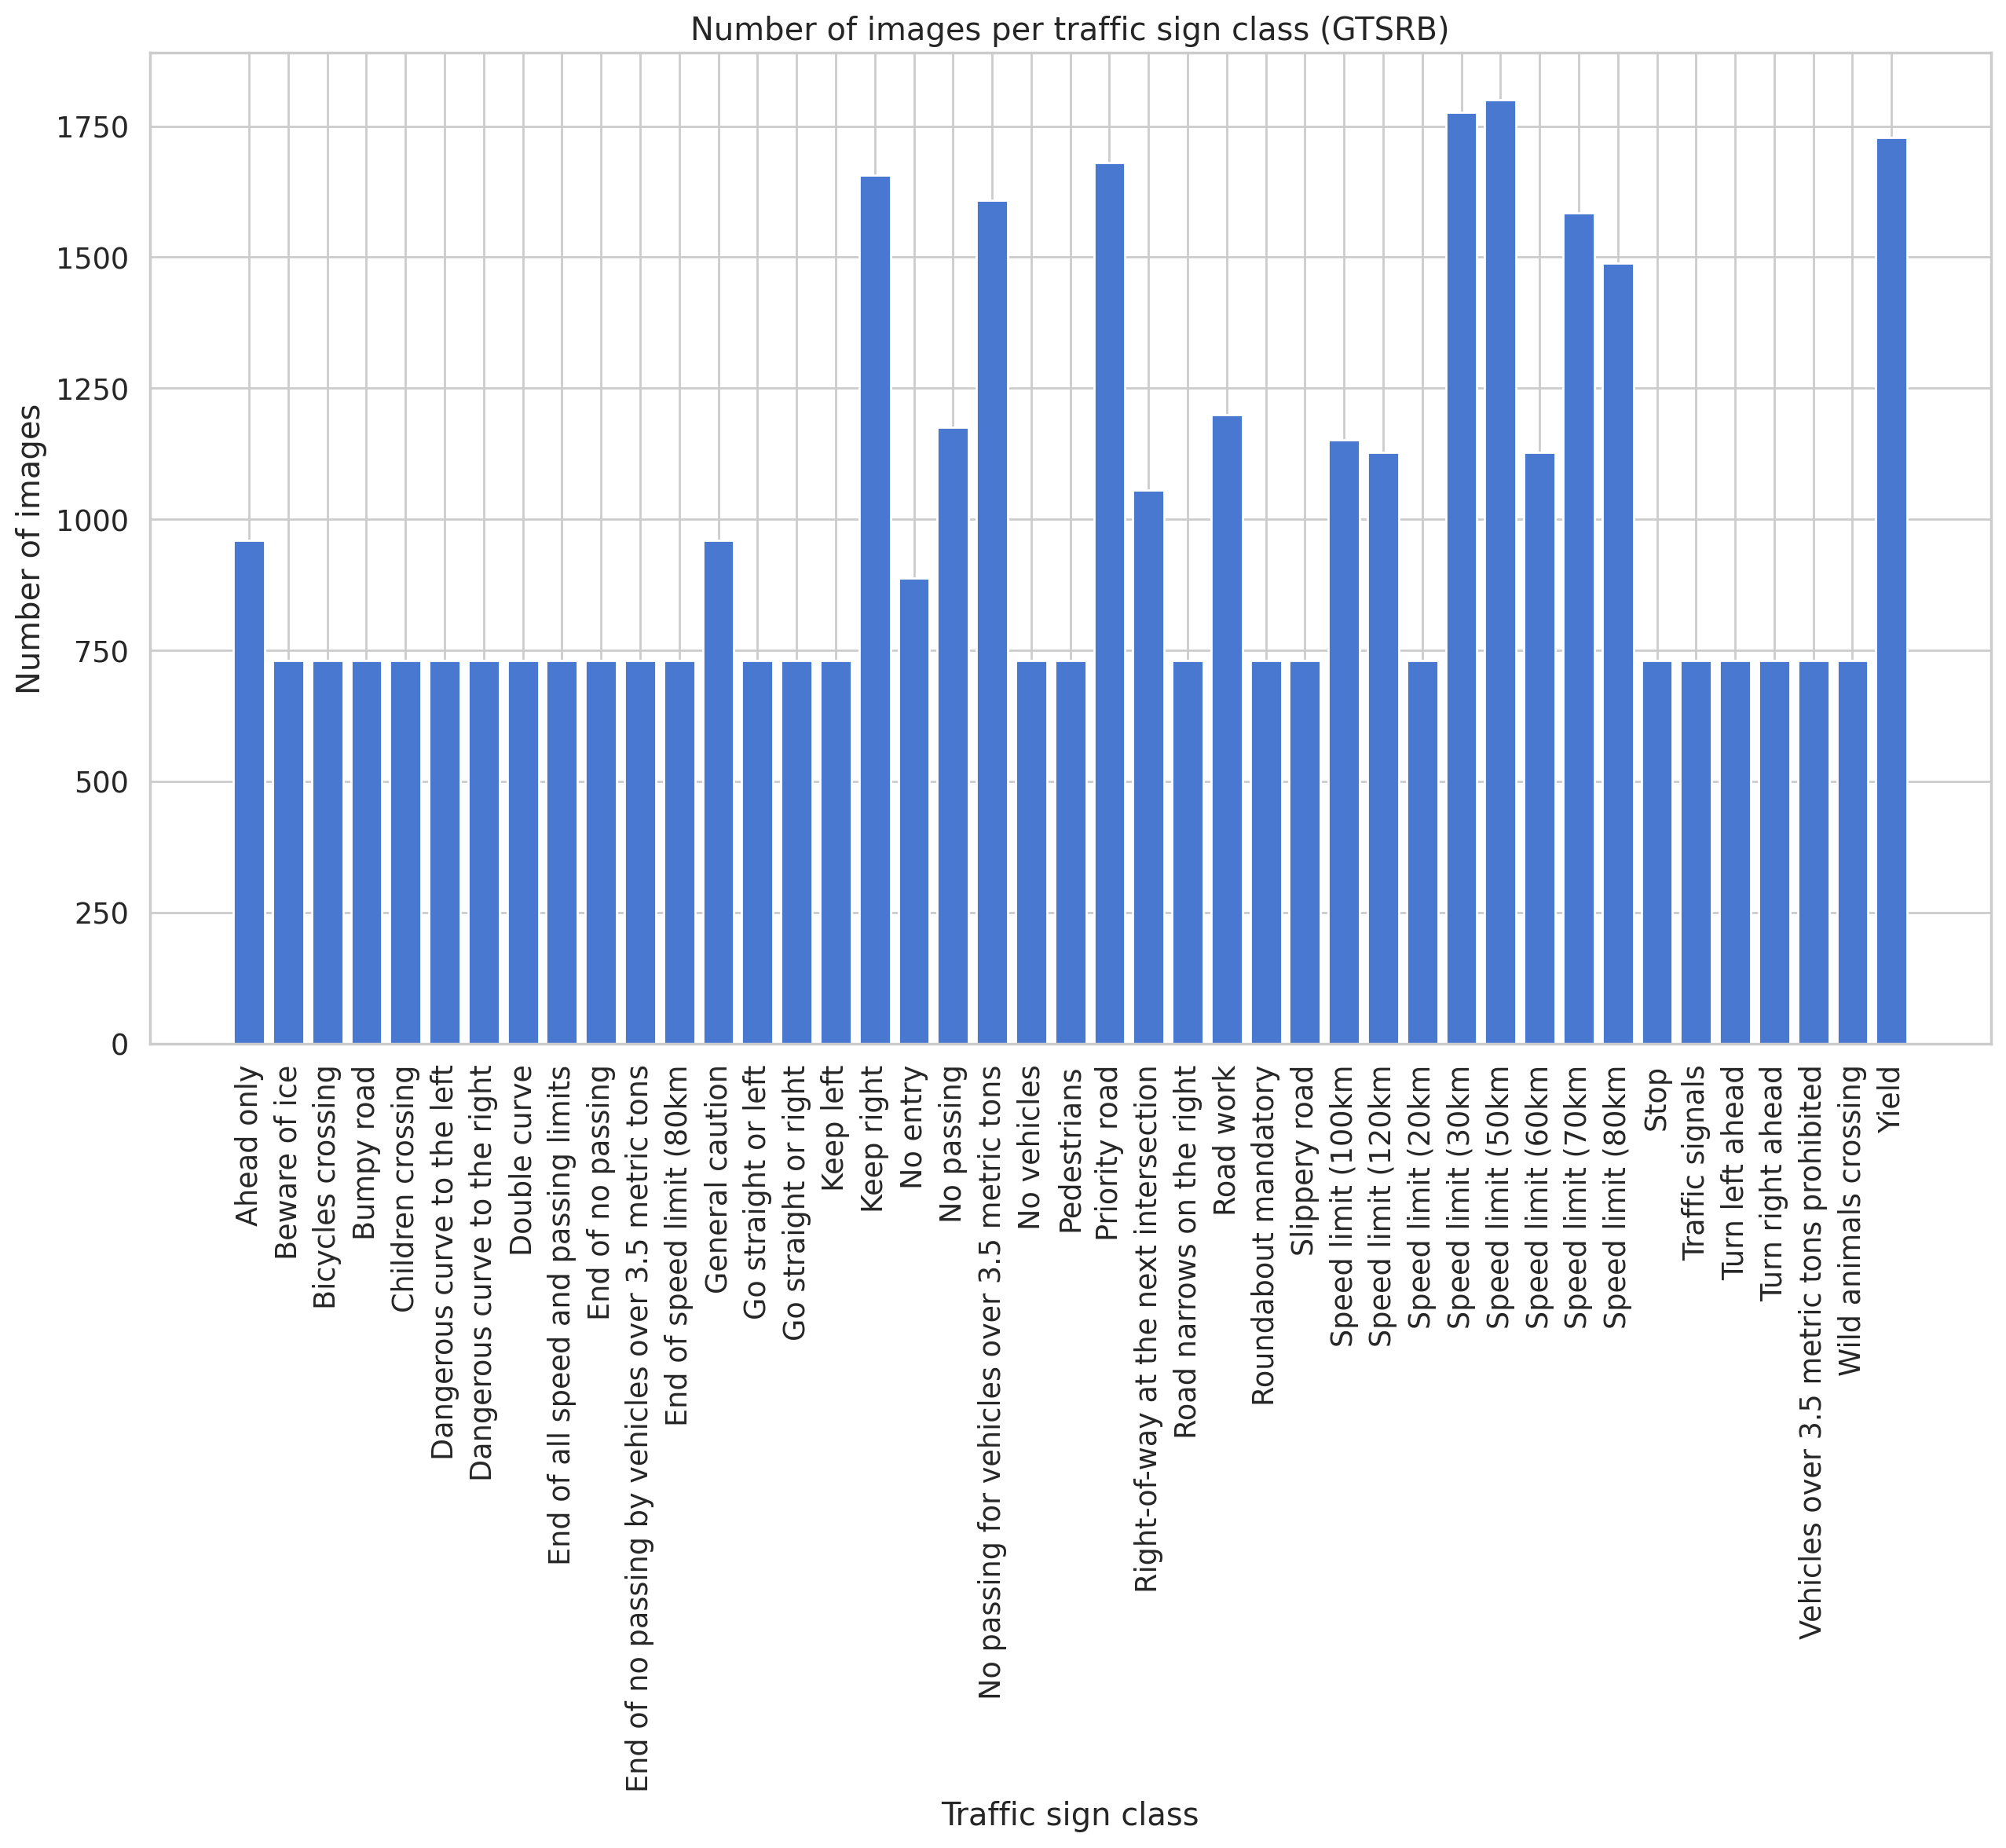

In [ ]:
TRAIN_DIR = Path(DATA_DIR) / "train"

train_folders_disk = sorted([p for p in TRAIN_DIR.iterdir() if p.is_dir()])

class_counts = {}
class_images = {}

for cd in train_folders_disk:
    imgs = list(Path(cd).rglob("*.ppm"))
    class_counts[cd.name] = len(imgs)
    class_images[cd.name] = imgs

counts = list(class_counts.values())
mean_count = int(math.ceil(np.mean(counts)))

print(f"Number of classes (train): {len(train_folders_disk)}")
print(f"Mean images per class (train): {mean_count}")
print(f"Min/Max before: {min(counts)} / {max(counts)}")
counts = list(class_counts.values())

plt.figure(figsize=(13, 12))
plt.bar(range(len(counts)), counts)

plt.xlabel("Traffic sign class")
plt.ylabel("Number of images")
plt.title("Number of images per traffic sign class (GTSRB)")

plt.xticks(
    ticks=range(len(counts)),
    labels=class_counts.keys(),
    rotation=90
)

plt.tight_layout()
plt.show()

This function looks at all images in the training dataset and computes:
*  the average pixel value (mean) for each color channel (R, G, B)
*  the spread of pixel values (standard deviation) for each channel.

These numbers are later used to normalize images before feeding them into a neural network.

In [ ]:
def compute_dataset_statistics(dataset_path):

    image_paths = []
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith('.ppm'):
                    image_paths.append(os.path.join(class_path, img_file))

    print(f"Processing {len(image_paths)} images...")

    pixel_sum = np.zeros(3)
    pixel_squared_sum = np.zeros(3)
    total_pixels = 0

    #Process images
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]

        pixel_sum += img.sum(axis=(0, 1))
        pixel_squared_sum += (img ** 2).sum(axis=(0, 1))
        total_pixels += img.shape[0] * img.shape[1]

    mean = pixel_sum / total_pixels
    std = np.sqrt(pixel_squared_sum / total_pixels - mean ** 2)

    print(f"Mean: [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
    print(f"Std:  [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")

    return mean.tolist(), std.tolist()

train_path = 'data/train'  # After you've created your subset
mean_nums, std_nums = compute_dataset_statistics(train_path)

Processing 31028 images...


100%|██████████| 31028/31028 [00:06<00:00, 4851.10it/s]

Mean: [0.3441, 0.3210, 0.3325]
Std:  [0.2766, 0.2673, 0.2755]


Doing preprocessing, normalization, and loading pipeline for the dataset, ensuring that all images are resized to a fixed resolution, normalized using training-set statistics

In [ ]:
IMG_SIZE = 64

transforms = {
  "train": T.Compose([
      T.Resize((IMG_SIZE, IMG_SIZE)),
      T.ToTensor(),
      T.Normalize(mean_nums, std_nums),
  ]),
  "val": T.Compose([
      T.Resize((IMG_SIZE, IMG_SIZE)),
      T.ToTensor(),
      T.Normalize(mean_nums, std_nums),
  ]),
  "test": T.Compose([
      T.Resize((IMG_SIZE, IMG_SIZE)),
      T.ToTensor(),
      T.Normalize(mean_nums, std_nums),
  ]),
}

We create datasets and data loaders for the training, validation, and test splits. Images are preprocessed with transforms, and fed to the model in batches. The training data is shuffled to improve learning, while validation and test data are kept in a fixed order to ensure stable evaluation. Parallel data loading is used to improve training efficiency

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True,  num_workers=2, pin_memory=True),
  'val':   DataLoader(image_datasets['val'],   batch_size=64, shuffle=False, num_workers=2, pin_memory=True),
  'test':  DataLoader(image_datasets['test'],  batch_size=64, shuffle=False, num_workers=2, pin_memory=True),
}

Check the number of images in sets

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
print(dataset_sizes)

{'train': 41948, 'val': 3921, 'test': 3921}


We visualize a batch of training images after preprocessing and normalization to verify that the data pipeline is correct and labels match the images

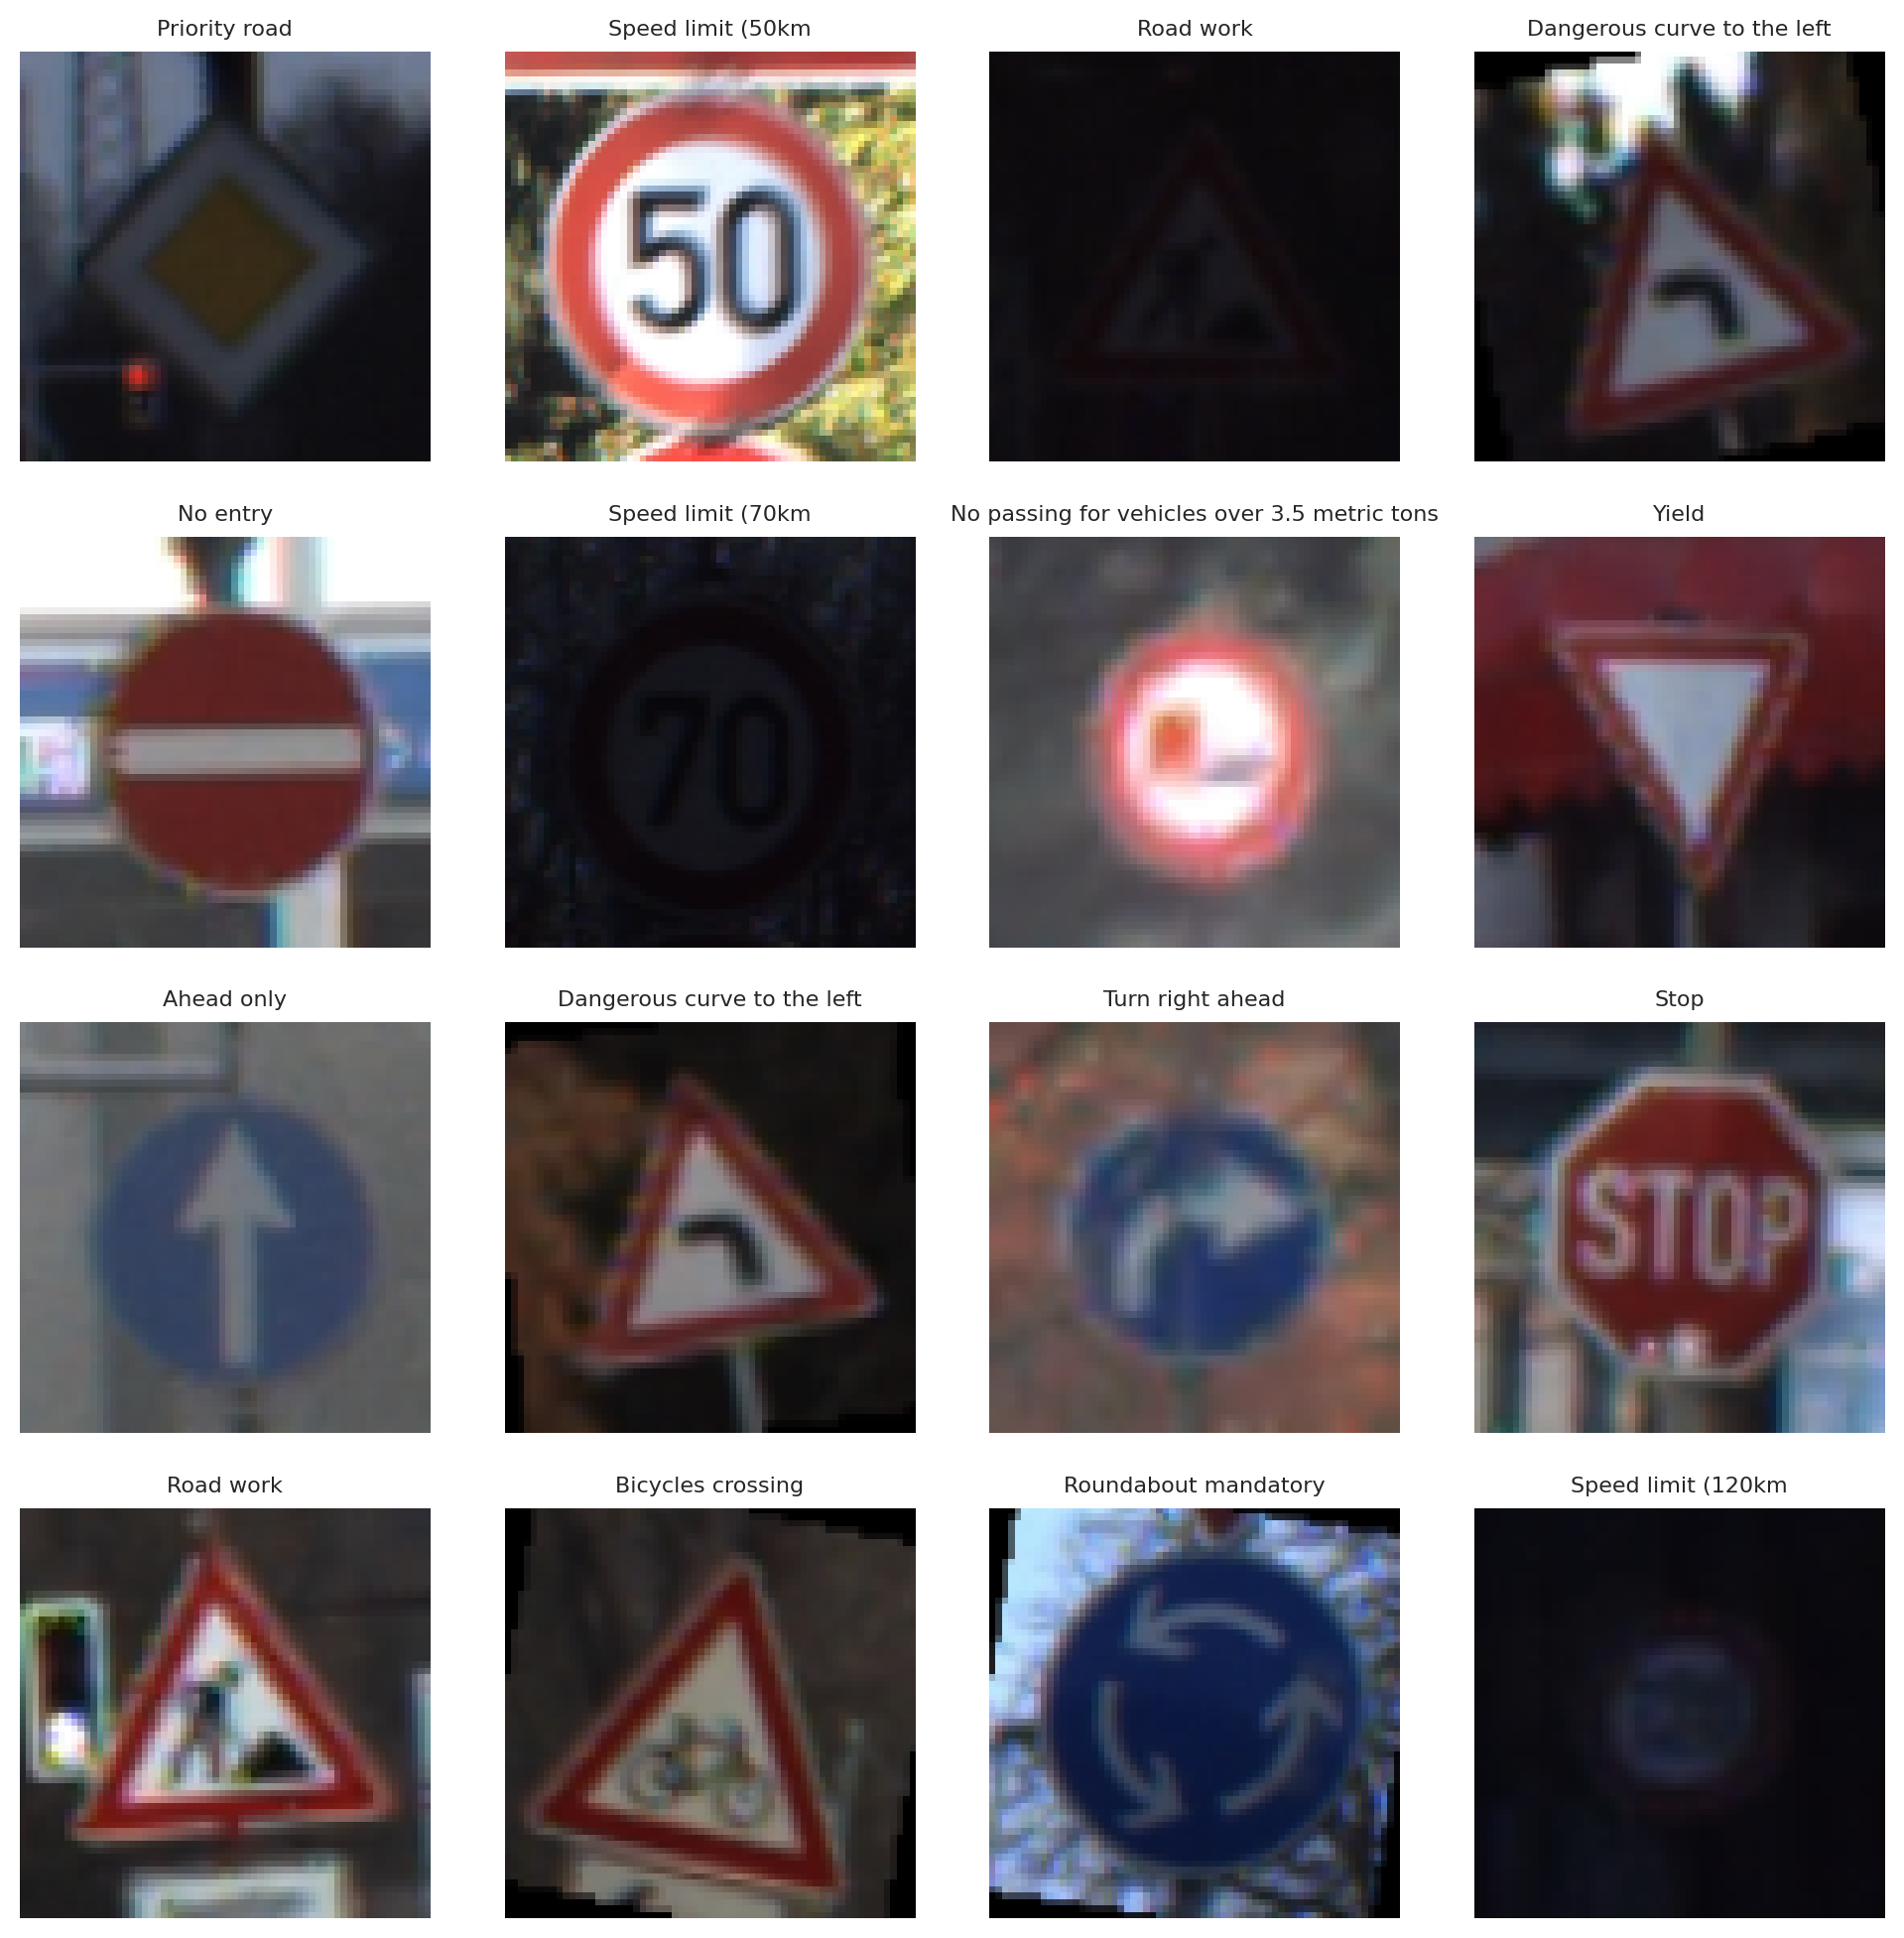

In [ ]:
inputs, classes = next(iter(data_loaders['train']))

plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i].numpy().transpose((1, 2, 0))
    img = std_nums * img + mean_nums
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(class_names[classes[i]], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

##Model training

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb

In [ ]:
wandb.login()

We implement a custom convolutional neural network designed for 64×64 RGB traffic sign images. The model consists of five convolutional blocks with batch normalization and max pooling, followed by global average pooling and a fully connected classifier. Dropout is used to reduce overfitting.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super().__init__()

        #Layer 1: 64x64x3 to 32x32x64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        #Layer 2: 32x32x64 to 32x32x128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #Layer 3: 32x32x128 to 16x16x256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        #Layer 4: 16x16x256 to 8x8x512
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        #Layer 5: 8x8x512 to 8x8x512
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        #Conv -> BN -> ReLU -> Pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))

        #Global pooling and flatten
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        #Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x


#Test the model
model = TrafficSignCNN(num_classes=43)
model = model.to(device)

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024*1024):.2f} MB")

Total parameters: 4,985,899
Trainable parameters: 4,985,899
Model size: 19.02 MB


###Detecting unknown objects
Given one image, run the classifier, compute probabilities, take the most likely class and its confidence.
If the confidence is below a threshold (e.g., 0.7), return "unknown" instead of forcing a wrong label.

In [ ]:
def predict_with_unknown(model, image_tensor, class_names, confidence_threshold=0.7):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        probability = F.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probability, dim=0)

        predicted_idx = predicted_idx.item()
        confidence = confidence.item()

        if confidence < confidence_threshold:
            return "unknown", confidence, None
        else:
            return class_names[predicted_idx], confidence, predicted_idx

###Training Setup and Optimization Strategy

We use CrossEntropyLoss for multi-class classification.

The model parameters are optimized using SGD with momentum. SGD updates model weights by following the gradient of the loss function, while the momentum term adds a fraction of the previous update to the current one.

A StepLR scheduler is applied to gradually reduce the learning rate during training. As the model approaches a good solution, the learning rate scheduler reduces the step size, which helps prevent oscillations and stabilizes training.



In [ ]:
LR = 0.01
MOMENTUM = 0.8
STEP_SIZE = 4
GAMMA = 0.1
NUM_EPOCHS = 8
CONFIDENCE_THRESHOLD = 0.7

criterion = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

optimizer = SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
print(f"Optimizer: SGD with lr={LR}, momentum={MOMENTUM}")

scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(f"Scheduler: reduce LR by {GAMMA} every {STEP_SIZE} epochs")

#Training
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        #Zero gradients
        optimizer.zero_grad()

        #Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #Backward pass
        loss.backward()

        #Update weights
        optimizer.step()

        #Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    acc = 100.0 * correct / total
    return avg_loss, acc

#Validation
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    acc = 100.0 * correct / total
    return avg_loss, acc


Loss function: CrossEntropyLoss
Optimizer: SGD with lr=0.01, momentum=0.8
Scheduler: reduce LR by 0.1 every 4 epochs


epoch,▁▂▃▅▆▇█
lr,███▁▁▁▁
train/accuracy,▁▁▄▅▇██
train/loss,█▇▅▄▂▁▁
val/accuracy,▁▄▇▆███
val/loss,█▅▃▃▁▁▁
epoch,7
lr,0.001
train/accuracy,99.94279
train/loss,0.00332
val/accuracy,99.87248


Starting training for 8 epochs...
Training samples: 41948
Validation samples: 3921

Epoch 1/8
----------------------------------------
Train Loss: 2.5005, Train Acc: 25.64%
Val Loss: 1.2006, Val Acc: 58.51%
Learning Rate: 0.010000

Epoch 2/8
----------------------------------------
Train Loss: 0.6116, Train Acc: 80.16%
Val Loss: 0.2233, Val Acc: 93.42%
Learning Rate: 0.010000

Epoch 3/8
----------------------------------------
Train Loss: 0.1628, Train Acc: 95.09%
Val Loss: 0.2853, Val Acc: 90.67%
Learning Rate: 0.010000

Epoch 4/8
----------------------------------------
Train Loss: 0.0754, Train Acc: 97.86%
Val Loss: 0.3224, Val Acc: 91.00%
Learning Rate: 0.001000

Epoch 5/8
----------------------------------------
Train Loss: 0.0260, Train Acc: 99.40%
Val Loss: 0.0106, Val Acc: 99.72%
Learning Rate: 0.001000

Epoch 6/8
----------------------------------------
Train Loss: 0.0191, Train Acc: 99.56%
Val Loss: 0.0101, Val Acc: 99.72%
Learning Rate: 0.001000

Epoch 7/8
------------------

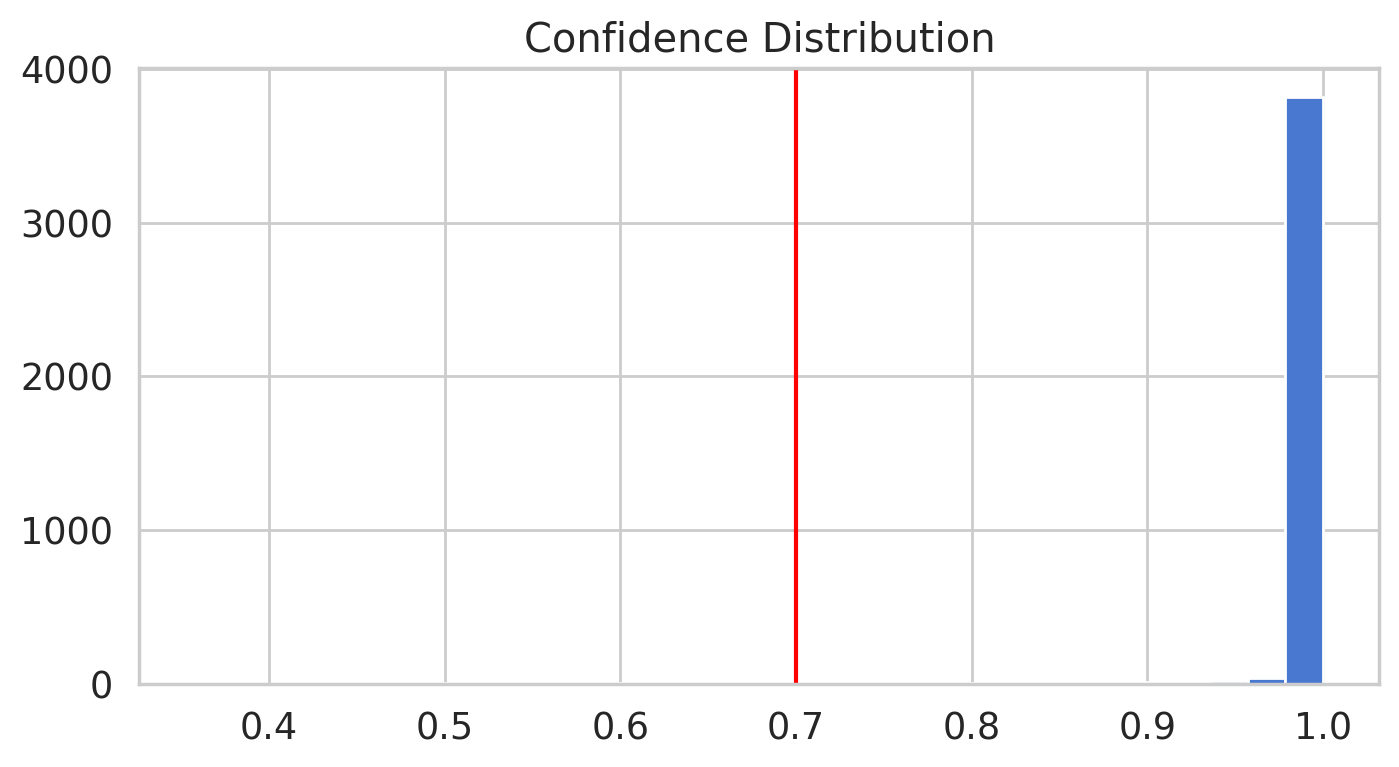

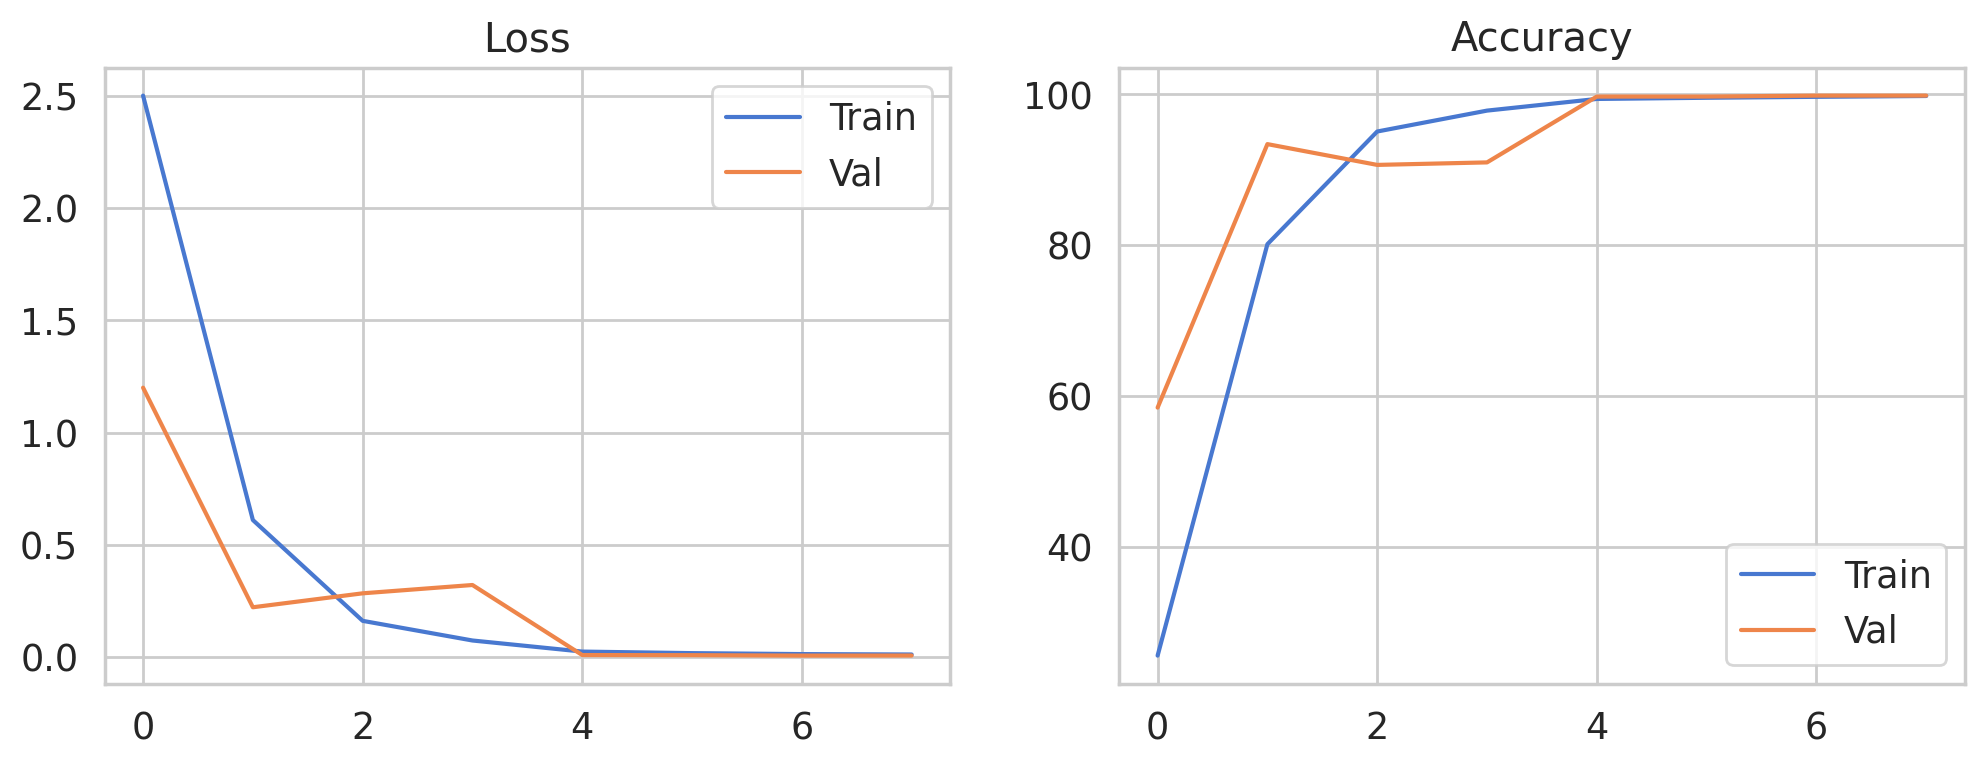

                                                    precision    recall  f1-score   support

                                        Ahead only     1.0000    1.0000    1.0000       120
                                     Beware of ice     1.0000    1.0000    1.0000        45
                                 Bicycles crossing     1.0000    1.0000    1.0000        27
                                        Bumpy road     1.0000    1.0000    1.0000        39
                                 Children crossing     1.0000    1.0000    1.0000        54
                       Dangerous curve to the left     1.0000    1.0000    1.0000        21
                      Dangerous curve to the right     1.0000    1.0000    1.0000        36
                                      Double curve     1.0000    1.0000    1.0000        33
               End of all speed and passing limits     1.0000    1.0000    1.0000        24
                                 End of no passing     1.0000    1.0000    1.00

epoch,▁▂▃▄▅▆▇█
lr,███▂▂▂▂▁
train/accuracy,▁▆██████
train/loss,█▃▁▁▁▁▁▁
val/accuracy,▁▇▆▇████
val/loss,█▂▃▃▁▁▁▁
classification_report,...
epoch,8
lr,0.0001
test_accuracy_highconf,99.61744
test_accuracy_standard,99.74496


In [ ]:
# W&B init
wandb.init(
    entity="svsshevchenko",
    project="Traffic_Sign_Classificator",
    config={
        "epochs": NUM_EPOCHS,
        "loss": "CrossEntropyLoss",
        "optimizer": "SGD",
        "lr": LR,
        "momentum": MOMENTUM,
        "scheduler": "StepLR",
        "step_size": STEP_SIZE,
        "batch size": 64,
        "gamma": GAMMA,
        "train_samples": dataset_sizes.get("train", None),
        "val_samples": dataset_sizes.get("val", None),
        "test_samples": dataset_sizes["test"],
        "confidence_threshold": CONFIDENCE_THRESHOLD,
    }
)

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")

start_time = time.time()

best_val_acc = 0.0
best_ckpt_path = "best_model.pt"

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)

    #Train
    train_loss, train_acc = train_epoch(
        model, data_loaders['train'], criterion, optimizer, device
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    #Validate
    val_loss, val_acc = validate(
        model, data_loaders['val'], criterion, device
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    #Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    #W&B logging
    wandb.log({
        "epoch": epoch + 1,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "val/loss": val_loss,
        "val/accuracy": val_acc,
        "lr": current_lr
    })

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")

    #Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_ckpt_path)

#Training complete
training_time = time.time() - start_time
print(f"\nTraining finished in {training_time:.1f}s")
print(f"Best Val Acc: {best_val_acc:.2f}%")


model.eval()
all_preds, all_labels, all_conf = [], [], []
std_correct, highconf_correct, total = 0, 0, 0

with torch.no_grad():
    for x, y in data_loaders["test"]:
        x, y = x.to(device), y.to(device)
        out = model(x)
        probs = F.softmax(out, dim=1)
        conf, pred = probs.max(1)

        total += y.size(0)
        std_correct += (pred == y).sum().item()
        highconf_correct += ((conf >= CONFIDENCE_THRESHOLD) & (pred == y)).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_conf.extend(conf.cpu().numpy())

std_acc = 100 * std_correct / total
highconf_acc = 100 * highconf_correct / total
unknown_count = sum(c < CONFIDENCE_THRESHOLD for c in all_conf)

print(f"\nStandard Test Accuracy: {std_acc:.2f}%")
print(f"High-Confidence Accuracy: {highconf_acc:.2f}%")
print(f"Unknown predictions: {unknown_count}/{total}")

wandb.summary.update({
    "test_accuracy_standard": std_acc,
    "test_accuracy_highconf": highconf_acc,
    "unknown_percent": 100 * unknown_count / total,
    "training_time_sec": training_time
})

#Confidence histogram
plt.figure(figsize=(8, 4))
plt.hist(all_conf, bins=30)
plt.axvline(CONFIDENCE_THRESHOLD, color="red")
plt.title("Confidence Distribution")
wandb.log({"confidence_hist": wandb.Image(plt.gcf())})
plt.show()

#Train / Val curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history["train_loss"], label="Train")
ax[0].plot(history["val_loss"], label="Val")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(history["train_acc"], label="Train")
ax[1].plot(history["val_acc"], label="Val")
ax[1].set_title("Accuracy")
ax[1].legend()

wandb.log({"training_curves": wandb.Image(fig)})
plt.show()

#Report
report = classification_report(
    all_labels, all_preds,
    target_names=class_names,
    digits=4
)
print(report)
wandb.summary["classification_report"] = report

#Save final model
torch.save(model.state_dict(), "my_traffic_sign_model.pth")
artifact = wandb.Artifact("final-model", type="model")
artifact.add_file("my_traffic_sign_model.pth")
wandb.log_artifact(artifact)

wandb.finish()

##Evaluation of the Classification Model



###1. Training Dynamics

The model was trained for 8 epochs on 41,948 training samples, with 3,921 validation samples.

Training loss decreased smoothly from 2.50 to 0.013. Validation loss decreased from 1.20 to 0.0085.

Training accuracy: 25.64% -> 99.79%. Validation accuracy: 58.5% -> 99.85%

**Both loss function curves go downward and converge after 5th epoch. This indicates stable optimization and good generalization.**

A temporary increase in validation loss around epochs 2–4 is observed. But it's not a sign of overfitting as it decreases again after the learning rate is reduced. It's more of a sign of optimization dynamics.

Training and validation accuracies converge to nearly identical values.
There is no gap between that confirms that the model does not memorize the training set.

###2. Test Set Performance
$\text{Precision} = \frac{TP}{TP + FP}$ - When the model predicts a class, how often is it correct?

For example: the lowest precision is for "Speed limit (20km)", which means it predicts the sign when it is not actually there.

$\text{Recall} = \frac{TP}{TP + FN}$ - Out of all real samples of class, how many did the model detect?

For example: the model was not always able to classify "Traffic signals" correctly.


$F1 = 2 \frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$ - How good is the model overall for this class, considering both mistakes and missed cases?

$F1_{\text{macro}} = \frac{1}{C} \sum_{i=1}^{C} F1_i$ - Does the model perform well across all classes, including rare ones?

Macro F1-score = 0.9978. Standard test accuracy = 99.74%

**The high and closely matching macro F1-score and test accuracy show that the model performs equally well across both frequent and rare classes.**

###3. Confidence Evaluation

* High-confidence accuracy: 99.62%

* Unknown predictions: 11 / 3921
High-Confidence Accuracy: 99.62%

The model is highly confident when it makes a decision


###4. Possible Issues
In this project, data augmentation was applied by generating augmented images and saving them directly into the training dataset, instead of performing transformations during training.

Because of this possible issues might occur:
1. **Reduced diversity across epochs.** The model sees the same augmented samples
every epoch. Consecutively, the model learns to recognize those specific augmented versions (e.g specific rotation angles), but might become less robust to unseen transformations.
2. **Larger dataset size and storage overhead.** Increases disk usage.

In our case those issues were not crucial, as:
* performance was precisely verified using validation and test metrics,
* traffic signs are designed to be easily recognizable (standardized shapes (circle, triangle, rectangle), colors (red, blue, white), high contrast symbols),
* we only augmented the classes with few images.

